# GTEx Data Exploration

In [246]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm.auto import tqdm
from cmapPy.pandasGEXpress.parse_gct import parse
from sklearn.model_selection import train_test_split
import numpy as np


In [211]:
# The full dataset is not tracked in the repo. You need to download it
full_data_path = '../../data/input/GTEx/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct'
mini_data_path = '../../data/input/GTEx/GTEx_mini_random.gct'

In [212]:
# calculate data split and metadata
file = open(mini_data_path)
file.readline()
metadata = file.readline()
metadata = metadata.split('\t')
data_nr_rows = int(metadata[0])
print(data_nr_rows)
data_nr_cols = int(metadata[1])
print(data_nr_cols)
train_chunks_size = int(data_nr_rows * 0.6)
val_chunks_size = int(data_nr_rows * 0.2)
test_chunks_size = int(data_nr_rows * 0.2)
print(train_chunks_size)
print(val_chunks_size)
print(test_chunks_size)


56200
1000
33720
11240
11240


In [293]:
d = pd.read_csv(mini_data_path, skiprows=2, sep="\t")
gene_ids = d['Name']

In [294]:
def process_batch(batch):
    batch.drop(batch.columns[[0, 1]], axis=1, inplace=True)
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(batch.to_numpy())
    df = pd.DataFrame(df_scaled)
    return df
    

In [309]:
class GTExDataset(Dataset):
    def __init__(self, nr_rows, type, transform=None):
        self.type = type
        self.chunks_reader = None
        self.nr_rows = nr_rows
        self.transform = transform
        self.current_chunk_nr = 0
        self.gene_names = []

    def __len__(self):
        return self.nr_rows
    
    def get_gene_names(self):
        return self.gene_names
    
    def __getitem__(self, idx):
        if idx == 0:
            self.refresh_reader()
            chunk = self.chunks_reader.get_chunk()
            self.current_chunk = process_batch(chunk)
            self.current_chunk_nr = 0
        if (int(idx / self.chunks_reader.chunksize)) > self.current_chunk_nr:
            self.current_chunk_nr += 1
            chunk = self.chunks_reader.get_chunk()
            self.current_chunk = process_batch(chunk)
        index = idx % self.chunks_reader.chunksize
        features = torch.tensor(self.current_chunk.iloc[index], dtype=torch.float32)

        if self.transform:
            features = self.transform(features)

        return features, features # for Autoencoder
    
    def refresh_reader(self):
        if self.type == 'train':
            self.chunks_reader = pd.read_csv(mini_data_path, skiprows=3, sep="\t", chunksize=256, nrows= int(data_nr_rows * 0.6))
        elif self.type == 'val':
            self.chunks_reader = pd.read_csv(mini_data_path, skiprows=3 + train_chunks_size, sep="\t", chunksize=256, nrows= val_chunks_size)
        else:
            self.chunks_reader = pd.read_csv(mini_data_path, skiprows=2 + train_chunks_size + val_chunks_size, sep="\t", chunksize=256, nrows= test_chunks_size - 1)



In [310]:
# Set hyperparameters
input_size = data_nr_cols
encoding_size = 5000
learning_rate = 1e-4
epochs = 10
batch_size = 256

In [311]:
train_dataset = GTExDataset(nr_rows=train_chunks_size, type='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = GTExDataset(nr_rows=val_chunks_size, type='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = GTExDataset(nr_rows=test_chunks_size, type='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [312]:
# Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, encoding_size)
        self.decoder = nn.Linear(encoding_size, input_size)
        self.nonlin = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = self.nonlin(x)
        x = self.decoder(x)
        x = self.nonlin(x)
        return x

In [313]:

# Initialize model, loss function, and optimizer
model = Autoencoder(input_size, encoding_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss_values = []
val_loss_values = []
# Training loop
for epoch in range(epochs):
    train_epoch_losses= []
    val_epoch_losses=[]
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss_values.append(np.mean(train_epoch_losses))
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {np.mean(train_epoch_losses):.4f}')

    # Val step
    with torch.no_grad():
        for inputs, targets in val_loader:
            model.eval()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_epoch_losses.append(loss.item())
        val_loss_values.append(np.mean(val_epoch_losses))
        print(f'Validation Loss: {np.mean(val_epoch_losses):.4f}')

Epoch [1/10], Loss: 0.0023
Validation Loss: 0.0016
Epoch [2/10], Loss: 0.0012
Validation Loss: 0.0013
Epoch [3/10], Loss: 0.0010
Validation Loss: 0.0012
Epoch [4/10], Loss: 0.0009
Validation Loss: 0.0011
Epoch [5/10], Loss: 0.0008
Validation Loss: 0.0010
Epoch [6/10], Loss: 0.0007
Validation Loss: 0.0009
Epoch [7/10], Loss: 0.0006
Validation Loss: 0.0009
Epoch [8/10], Loss: 0.0006
Validation Loss: 0.0009
Epoch [9/10], Loss: 0.0005
Validation Loss: 0.0008
Epoch [10/10], Loss: 0.0005
Validation Loss: 0.0008


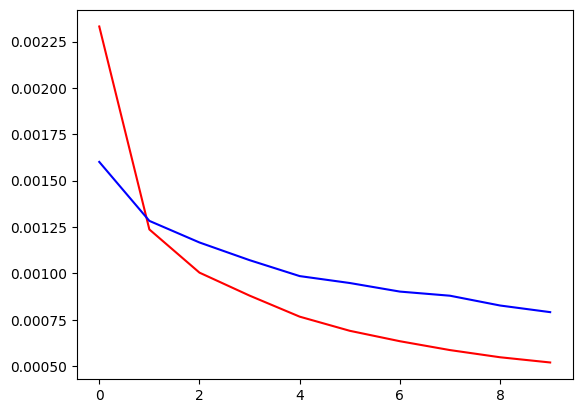

In [314]:
with torch.no_grad():
    plt.plot(np.array(train_loss_values), 'r')
    plt.plot(np.array(val_loss_values), 'b')

    

In [315]:
embeddings = []
# Extract embeddings
with torch.no_grad():
    model.eval()
    for inputs, _ in test_loader:
        x = model.encoder(inputs)
        embeddings.append(x)
embeddings = torch.vstack(embeddings)
len(embeddings)


IndexError: single positional indexer is out-of-bounds

In [316]:
emb_df = pd.DataFrame(
    data = embeddings,
    index = [f'index_{i}' for i in range(test_chunks_size)],
    columns = [f'EMB_{i}' for i in range(encoding_size)]
)
emb_df.index.name = "gene_id"
emb_df

ValueError: Must pass 2-d input. shape=(43, 256, 5000)

In [267]:
emb_df.to_csv(f"../../data/embeddings/GTEx_AE_embeddings_d{encoding_size}.tsv", sep="\t")